# K-Means
This notebook applies K-Means clustering to the three datasets contained in `../final/`. All of them contains information about the GDP and the CO2 emissions for each country, however, they are divided as:
- Every country (with time series) 
- European only countries (year 2024)
- Top-40 wealthies countries (year 2024)

## Step 0: Import and Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)

In [2]:
df_all = pd.read_csv('../data/final/gdp_co2_emissions_countries.csv')
df_europe = pd.read_csv('../data/final/gdp_co2_emissions_europe.csv')
df_top40 = pd.read_csv('../data/final/gdp_co2_emissions_top40_2024.csv')

In [3]:
df_all.head()

,Country Name,Country Code,Year,Total CO2 emissions,CO2 emissions per capita,GDP,GDP per capita,GDP growth (annual %)
0,Afghanistan,AFG,2000,1047127.94,0.052017,6.206548e+09,1617.826475,NaN
1,Afghanistan,AFG,2001,1069098.00,0.052706,5.621148e+09,1454.110782,-9.431974
2,Afghanistan,AFG,2002,1341065.00,0.062731,7.228796e+09,1774.308743,28.600001
3,Afghanistan,AFG,2003,1559679.00,0.068608,7.867263e+09,1815.928200,8.832278
4,Afghanistan,AFG,2004,1237247.00,0.052513,7.978516e+09,1776.918207,1.414118


In [4]:
df_europe.head()

,Country Name,Country Code,Year,Total CO2 emissions,CO2 emissions per capita,GDP,GDP per capita,GDP growth (annual %)
0,Albania,ALB,2024,4444448.0,1.591990,1.556837e+10,20591.486725,4.045928
1,Andorra,AND,2024,424663.0,5.181661,3.362287e+09,65928.307197,3.371820
2,Austria,AUT,2024,56367656.0,6.180112,4.218093e+11,63788.078678,-0.659090
3,Belarus,BLR,2024,55818416.0,6.163221,6.203002e+10,29040.972579,4.009849
4,Belgium,BEL,2024,85456200.0,7.279831,5.341789e+11,63347.785881,1.070454


In [5]:
df_top40.head()

,Country Name,Country Code,Year,Total CO2 emissions,CO2 emissions per capita,GDP,GDP per capita,GDP growth (annual %),Continent
0,United States,USA,2024,4.904120e+09,14.197287,2.256846e+13,75489.266433,2.793001,North America
1,China,CHN,2024,1.228904e+10,8.658390,1.848811e+13,23845.619722,4.977357,Asia
2,Japan,JPN,2024,9.618673e+08,7.772474,4.606003e+12,46106.922923,0.104309,Asia
3,Germany,DEU,2024,5.723192e+08,6.768824,3.677049e+12,62554.554723,-0.495852,Europe
4,India,IND,2024,3.193478e+09,2.200978,3.477821e+12,9818.042707,6.494766,Asia


All read correctly

 ---
## 1. Apply K-Means

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

### 1.1 All countries (2024)

In [7]:
df_clust = df_all[(df_all['GDP per capita'] > 0) & 
                  (df_all['CO2 emissions per capita'] > 0)].copy()
df_clust = df_clust[df_clust['Year'] == 2024]

df_clust['log_GDP_pc'] = np.log10(df_clust['GDP per capita'])
df_clust['log_CO2_pc'] = np.log10(df_clust['CO2 emissions per capita'])

# features for clustering
features = ['log_GDP_pc', 'log_CO2_pc']
# features_non_log = ['GDP per capita', 'CO2 emissions per capita']
X = df_clust[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

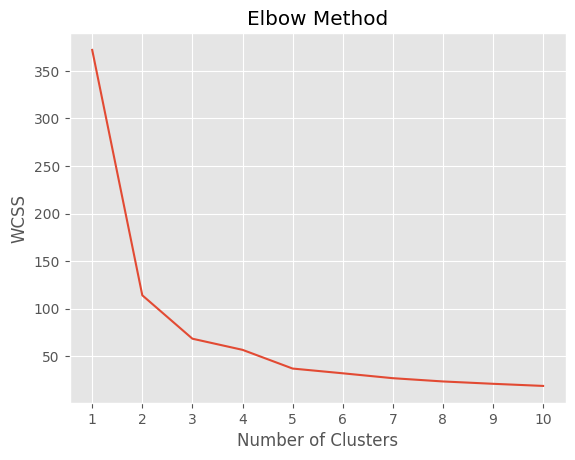

In [8]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.savefig('../outputs/plots/kmeans_elbow_all.png', dpi=300, bbox_inches='tight')
plt.show()

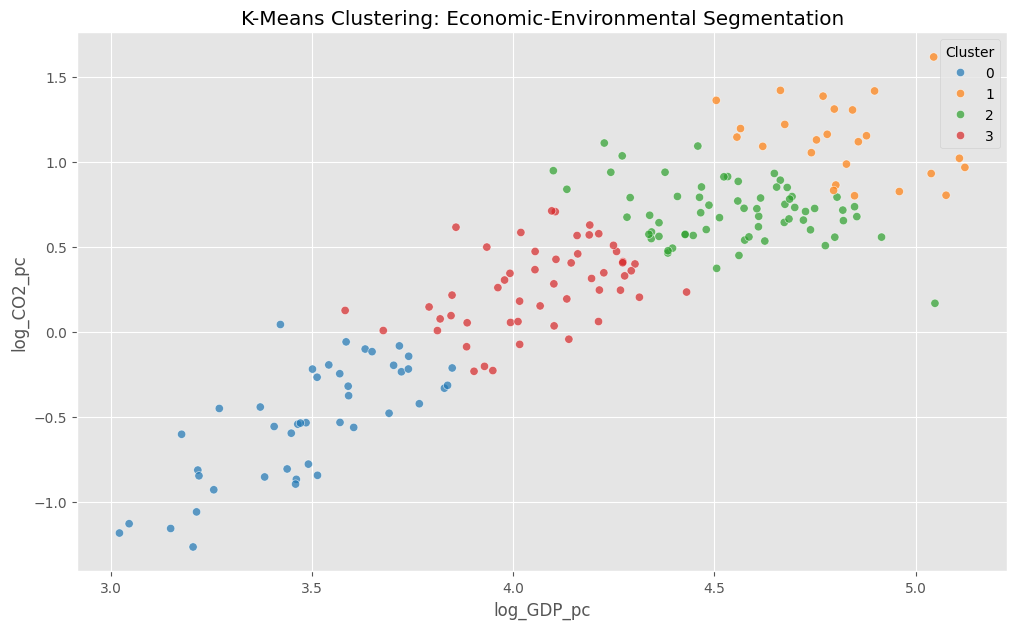

In [9]:
# elbow in K=4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
df_clust['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_clust, x='log_GDP_pc', y='log_CO2_pc', 
                hue='Cluster', palette='tab10', alpha=0.7)
plt.title('K-Means Clustering: Economic-Environmental Segmentation')
plt.savefig('../outputs/plots/kmeans_all.png', dpi=300, bbox_inches='tight')
plt.show()

### 1.2 European Countries only (2024) 

In [10]:
features = ['GDP per capita', 'CO2 emissions per capita']
X = df_europe[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

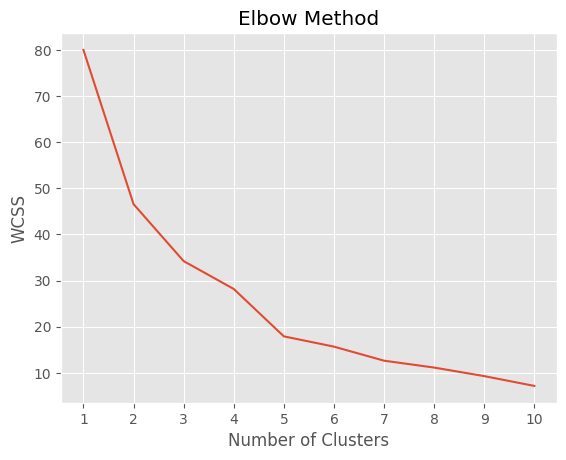

In [11]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.savefig('../outputs/plots/kmeans_elbow_europe.png', dpi=300, bbox_inches='tight')
plt.show()

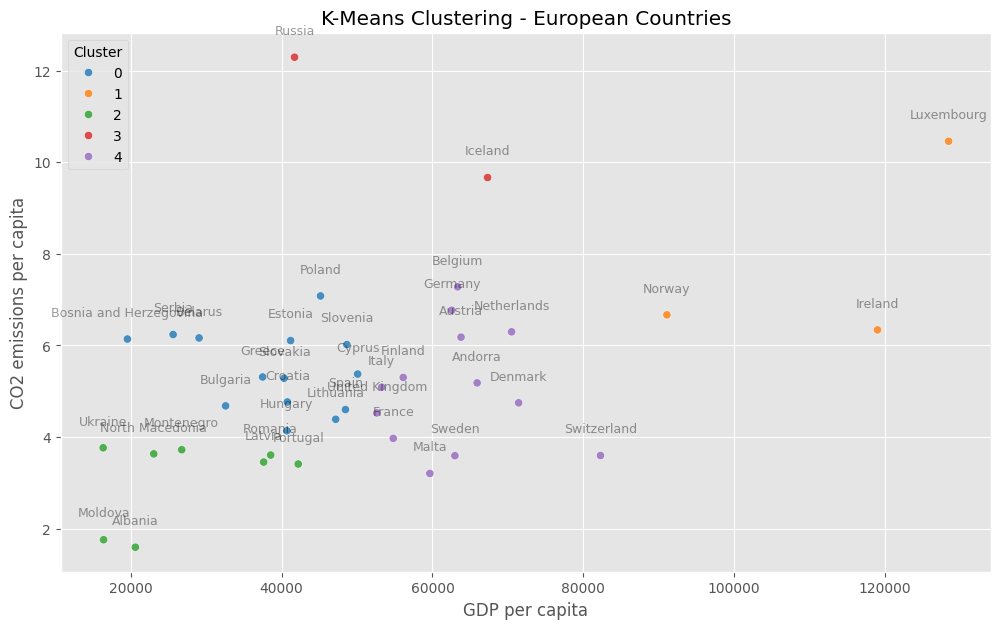

In [12]:
# elbow in K=5 clusters
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
df_europe['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_europe, x='GDP per capita', y='CO2 emissions per capita', 
                hue='Cluster', palette='tab10', alpha=0.8)
for i in range(df_europe.shape[0]):
    plt.text(x=df_europe['GDP per capita'].iloc[i], 
             y=df_europe['CO2 emissions per capita'].iloc[i] + 0.5, 
             s=df_europe['Country Name'].iloc[i], 
             fontsize=9, 
             alpha=0.4,
             ha='center') 
plt.title('K-Means Clustering - European Countries')
plt.savefig('../outputs/plots/kmeans_europe.png', dpi=300, bbox_inches='tight')
plt.show()

### 1.3 Top-40 Countries only (2024)


In [13]:
features = ['GDP per capita', 'CO2 emissions per capita']
X = df_top40[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

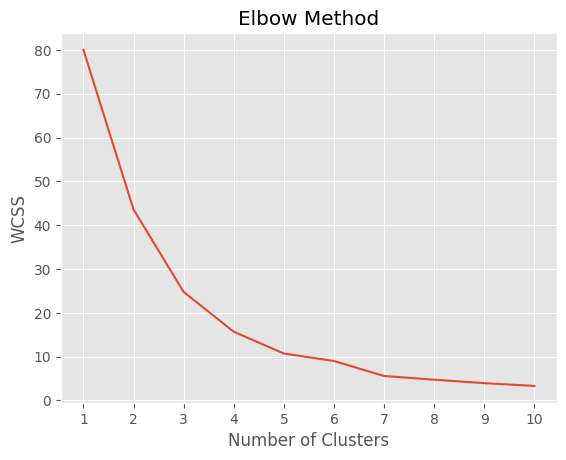

In [14]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.savefig('../outputs/plots/kmeans_elbow_top40.png', dpi=300, bbox_inches='tight')
plt.show()

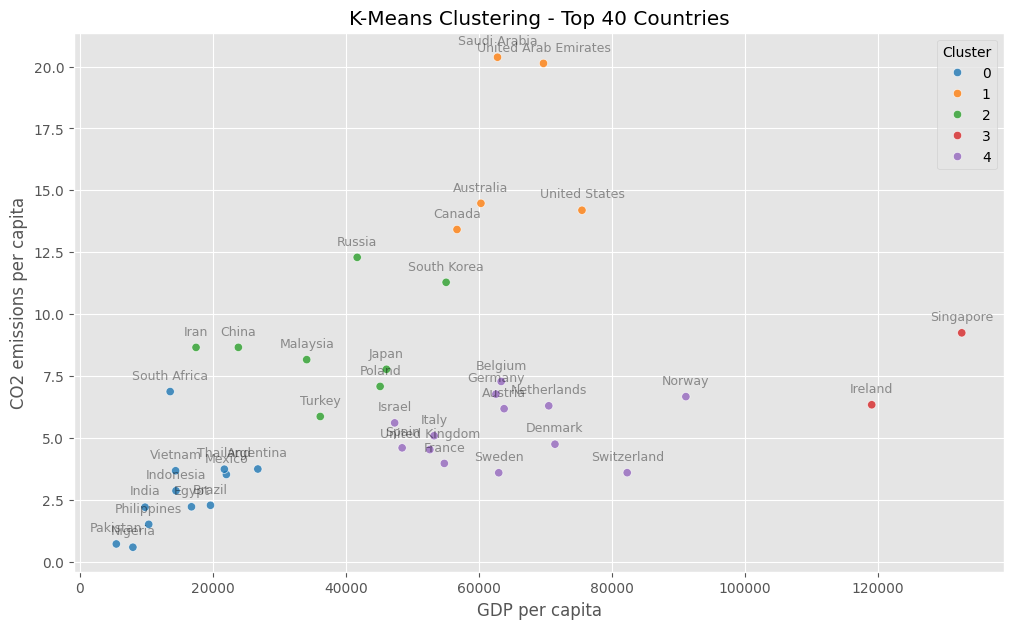

In [15]:
# elbow in K=5 clusters
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
df_top40['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_top40, x='GDP per capita', y='CO2 emissions per capita', 
                hue='Cluster', palette='tab10', alpha=0.8)
for i in range(df_top40.shape[0]):
    plt.text(x=df_top40['GDP per capita'].iloc[i], 
             y=df_top40['CO2 emissions per capita'].iloc[i] + 0.5, 
             s=df_top40['Country Name'].iloc[i], 
             fontsize=9, 
             alpha=0.4,
             ha='center') 
plt.title('K-Means Clustering - Top 40 Countries')
plt.savefig('../outputs/plots/kmeans_top40.png', dpi=300, bbox_inches='tight')
plt.show()